In [2]:
library(dggridR)
library(rgdal)
library(rgeos)
library(dplyr)
library(geosphere)
#library(doParallel)
#library(tictoc)

In [3]:
dginfo(dgconstruct('ISEA',3,'HEXAGON',30))

   res            cells                area_km      spacing_km          cls_km
1    0               12 51006562.1724088713527 7053.6524314108 8199.5003701020
2    1               32 17002187.3908029571176 4072.4281300451 4678.9698717297
3    2               92  5667395.7969343187287 2351.2174771369 2691.2520709129
4    3              272  1889131.9323114396539 1357.4760433484 1551.8675487723
5    4              812   629710.6441038132180  783.7391590456  895.6018416484
6    5             2432   209903.5480346044060  452.4920144495  517.0049969031
7    6             7292    69967.8493448681256  261.2463863485  298.4793231872
8    7            21872    23322.6164482893764  150.8306714832  172.3244908961
9    8            65612     7774.2054827631255   87.0821287828   99.4910857272
10   9           196832     2591.4018275877088   50.2768904944   57.4411078487
11  10           590492      863.8006091959029   29.0273762609   33.1636203580
12  11          1771472      287.9335363986343   16.

NULL

In [4]:
# read arguments, resolution level and grid ID
dggs_res = 19

# get number of cores, register at the backend
# ncores = as.numeric(Sys.getenv("SLURM_CPUS_PER_TASK")) 
# Shows the number of Parallel Workers to be used
# registerDoParallel(cores=ncores)

# construct a look-up table, storing resolution and corresponding cell size and vertical resolution
res_list = c(16,17,18,19,20,21,22,23,24,25,26,27,28,29)
cell_size_list = c(0.005,0.003,0.001,0.0009,0.0008,0.0006,0.0003,0.0002,0.0001,0.00006,0.00003,0.00002,0.00001,0.000005)
vertical_res_list = c(0,0,0,1,1,2,2,3,3,4,4,5,5,6)
look_up = data.frame("res_list" = res_list,"cell_size_list" = cell_size_list,"vertical_res_list" = vertical_res_list)

print(look_up)

# look up cell size and vertical resolution
dggs_cellsize = look_up$cell_size_list[look_up$res_list == dggs_res]
vertical_res = look_up$vertical_res_list[look_up$res_list == dggs_res]

   res_list cell_size_list vertical_res_list
1        16          5e-03                 0
2        17          5e-03                 0
3        18          3e-03                 0
4        19          1e-03                 1
5        20          8e-04                 1
6        21          6e-04                 2
7        22          3e-04                 2
8        23          2e-04                 3
9        24          1e-04                 3
10       25          7e-05                 4
11       26          3e-05                 4
12       27          2e-05                 5
13       28          1e-05                 5
14       29          5e-06                 6


In [5]:
# define DGGS
v_lat = 37.6895
v_lon = -51.6218
azimuth = 360-72.6482
DGG = dgconstruct(projection="ISEA", aperture=3, topology="HEXAGON", res=dggs_res, azimuth_deg=azimuth, pole_lat_deg=v_lat, pole_lon_deg=v_lon)

In [6]:
# read study area shapefile
study_area = readOGR(dsn="Data",layer='study_area')
study_area = bbox(study_area[1,])

# get study area info
minx = study_area[1,1]
miny = study_area[2,1]
maxx = study_area[1,2]
maxy = study_area[2,2]

# generate cell centroids 
coords = matrix(c(minx, miny, maxx, miny, maxx, maxy, maxx, miny, minx, miny), ncol = 2, byrow = TRUE)
regbox = Polygon(coords)
regbox = SpatialPolygons(list(Polygons(list(regbox), ID = "a")))
centroids = sp::makegrid(regbox, cellsize = dggs_cellsize)
centroids$Cell_address = dgGEO_to_SEQNUM(DGG,centroids$x1, centroids$x2)$seqnum
centroids = centroids[!duplicated(centroids$Cell_address),]
centroids$lon_c = dgSEQNUM_to_GEO(DGG,centroids$Cell_address)$lon_deg
centroids$lat_c = dgSEQNUM_to_GEO(DGG,centroids$Cell_address)$lat_deg
centroids = subset(centroids, select = -c(x1,x2) )

print(nrow(centroids))
print(head(centroids,10))

write.csv(centroids,"Result/centroids.csv", row.names = FALSE)

Warning message in OGRSpatialRef(dsn, layer, morphFromESRI = morphFromESRI, dumpSRS = dumpSRS, :
"Discarded datum D_North_American_1983_CSRS in Proj4 definition: +proj=longlat +ellps=GRS80 +no_defs"


OGR data source with driver: ESRI Shapefile 
Source: "G:\UCalgary Research\NRCan_NationalDEM\Experiment_DEM_Oct\Workflow_demo\Data", layer: "study_area"
with 1 features
It has 1 fields
Integer64 fields read as strings:  FID 
[1] 2116
   Cell_address     lon_c    lat_c
1    5002019930 -78.34865 44.77498
4    5001980564 -78.34630 44.77607
6    5001960881 -78.34403 44.77499
9    5001921515 -78.34169 44.77608
10   5001941199 -78.34176 44.77391
11   5001901832 -78.33942 44.77501
14   5001882150 -78.33715 44.77393
15   5001842783 -78.33481 44.77502
18   5001823101 -78.33253 44.77394
20   5001783734 -78.33019 44.77503


In [7]:
# create hexagons in shapefile
grid =dgrectgrid(DGG, minlat = miny, minlon = minx, maxlat = maxy, maxlon = maxx, cellsize = dggs_cellsize, frame=FALSE)
centroids = centroid(grid)
grid = as(grid, "SpatialPolygonsDataFrame")
grid@data$dummy = dgGEO_to_SEQNUM(DGG,centroids[,1], centroids[,2])$seqnum
writeOGR(grid, "Result", layer = "hexagon_grids", driver='ESRI Shapefile')

print('Create hexagonal grids successfully!')

[1] "Create hexagonal grids successfully!"


OGR data source with driver: ESRI Shapefile 
Source: "G:\UCalgary Research\NRCan_NationalDEM\Experiment_DEM_Oct\Workflow_demo\Result", layer: "hexagon_grids"
with 2116 features
It has 1 fields


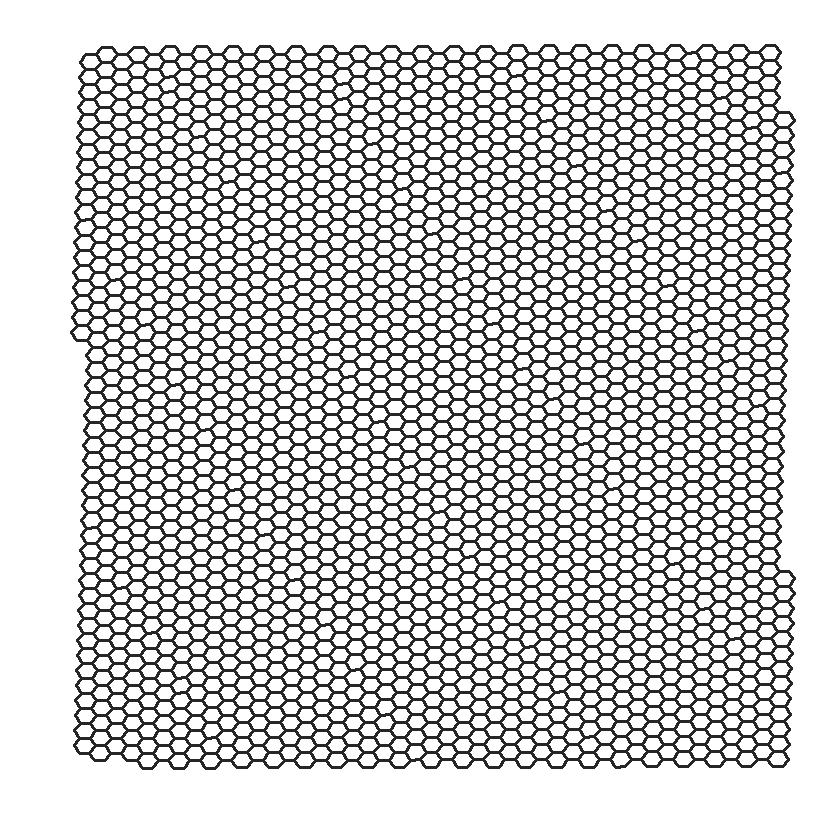

In [8]:
# plot hexagon_grids
library(ggplot2)
hexagon_grids = readOGR(dsn="Result",layer="hexagon_grids")
hexagon_grids@data$seq_id <- seq(1:nrow(hexagon_grids@data))
hexagon_grids@data$id <- rownames(hexagon_grids@data)
hexagon_grids_data <- fortify(hexagon_grids, region = "id")
hexagon_grids_df <- merge(hexagon_grids_data, hexagon_grids@data, by = "id")

ggplot(data = hexagon_grids_df, aes(x = long, y = lat, group = group)) +
    geom_polygon(size=1, fill=NA, alpha=0.3, color="gray15") + 
    xlab('')+ylab('')+
    theme(axis.ticks.x=element_blank())+
    theme(axis.ticks.y=element_blank())+
    theme(axis.text.x=element_blank())+
    theme(axis.text.y=element_blank())+
    theme(panel.background = element_blank())